# Outline
- [ 1 - Import Data and EDA](#1)
- [ 2 - ML models](#2)
  - [ 2.1 - SVM](#2.1)
  - [ 2.2 - Naive Bayes](#2.2)
  - [ 2.3 - Logistic Regression](#2.3)
- [ 3 - Neuron networks](#3)
  - [ 3.1 - Convolutional NN](#3.1)
  - [ 3.2 - LSTM](#3.2)
  - [ 3.3 - Bidirectional LSTM](#3.3)
- [ 4 - Pretrained NN (DistilBert)](#4)


<br> Dataset is provided by [`Kaggle Fake News Competition`](https://www.kaggle.com/competitions/fake-news/data)

<a name="1"></a>
## 1 - Import Data and EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM, Dropout, Bidirectional

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/train.csv", on_bad_lines='skip',sep=',')
evaluation_data = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/test.csv", on_bad_lines='skip',sep=',')

In [4]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
for i in ["title", "author", "text"]:
    if i=="author":
        train[i] = train[i].fillna('unknown')
    train[i] = train[i].fillna('unknown')
    evaluation_data[i] = evaluation_data[i].fillna('unknown')

In [6]:
target_names = ["Unreliable", "Reliable"]

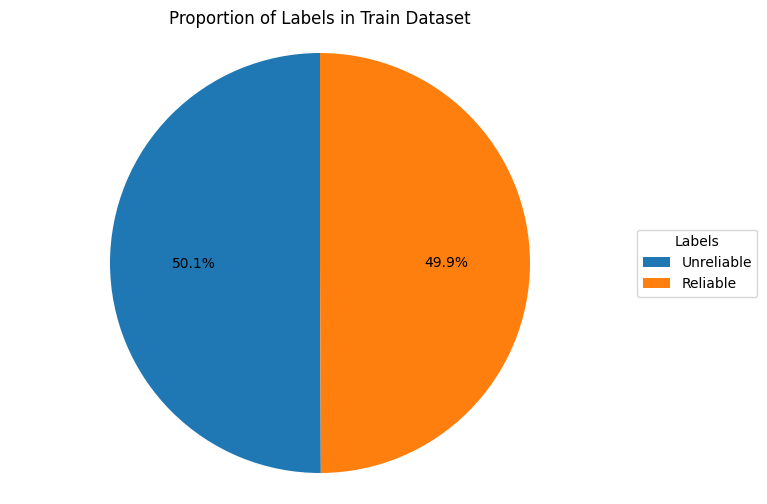

In [7]:
label_counts = train['label'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(label_counts, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
ax.set_title('Proportion of Labels in Train Dataset')
ax.legend(wedges, target_names, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [8]:
def plot_words_cloud(data, title):
    text = ' '.join(data)

    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

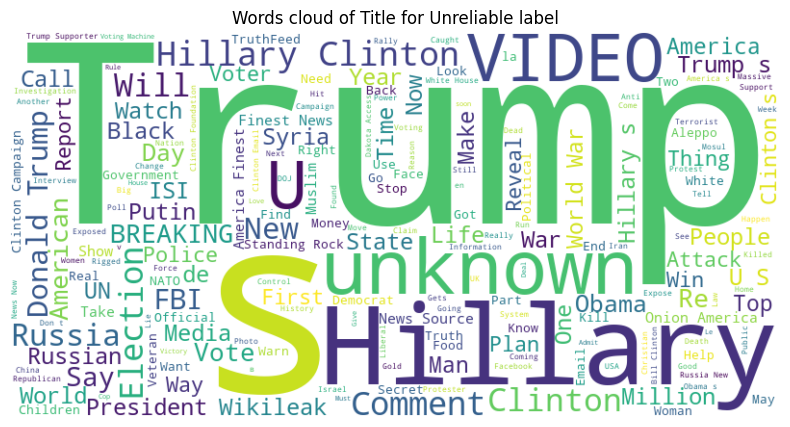

In [9]:
plot_words_cloud(train[train["label"]==1]["title"], "Words cloud of Title for " + target_names[0] + " label")

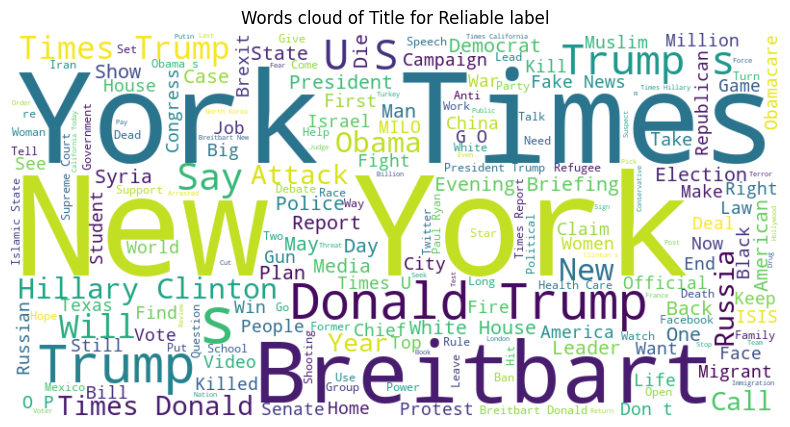

In [10]:
plot_words_cloud(train[train["label"]==0]["title"], "Words cloud of Title for " + target_names[1] + " label")

In [11]:
def text_prepare(text, stemming = True):
    """
    Function that does a general text preparation

    Parameters:
    text: corpus of text documents

    Output:

    text without spetial characters, "stop words" in lower case and stemmed
    """
    stemmer = PorterStemmer()
    REPLACE_BY_SPACE_RE = re.compile(r'[^a-zA-Z0-9\s]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    if stemming:
        text = [stemmer.stem(w) for w in text.split() if not w in STOPWORDS]
    else:
        text = [w for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [12]:
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

For now let's combine train and validation datasets and use them together in training

In [13]:
train["all_test"] = train['title'] + " " + train["text"]
evaluation_data["all_test"] = evaluation_data['title'] + " " + evaluation_data["text"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['label']),train['label'], test_size=0.2, random_state = 42)

In [16]:
X_train_cleaned = [text_prepare(x) for x in X_train["all_test"]]
X_test_cleaned = [text_prepare(x) for x in X_test["all_test"]]

In [17]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [18]:
X_train_matrix = tfidf.fit_transform(X_train_cleaned)
X_test_matrix = tfidf.transform(X_test_cleaned)

In [19]:
tfidf_reversed_vocab = {i:word for word,i in tfidf.vocabulary_.items()}

<a name="2"></a>
## 2 - ML models

<a name="2.1"></a>
## 2.1 - SVM

In [20]:
from sklearn.calibration import CalibratedClassifierCV
svm_model = LinearSVC(C=10,random_state=42, max_iter=10000)
svm_model.fit(X_train_matrix, y_train)

LinearSVC(C=10, max_iter=10000, random_state=42)

In [23]:
calibrated_svc = CalibratedClassifierCV(svm_model, method='sigmoid', cv='prefit')

# Fit the calibrated model (calibration does not require a separate training set)
calibrated_svc.fit(X_train_matrix, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=LinearSVC(C=10, max_iter=10000,
                                           random_state=42))

In [24]:
y_pred = svm_model.predict(X_test_matrix)

# Classification report to evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2132
           1       0.98      0.96      0.97      2028

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



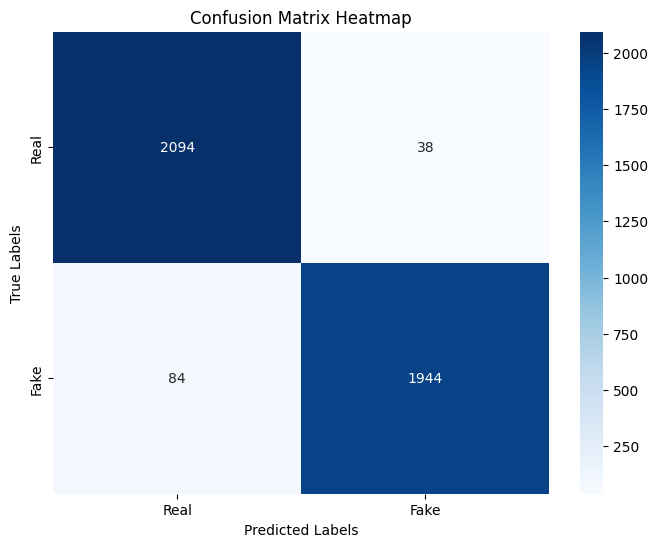

In [25]:
plot_confusion_matrix(y_test, y_pred)

<a name="2.2"></a>
## 2.2 - Naive Bayes

In [27]:
nb_model = MultinomialNB()
nb_model.fit(X_train_matrix, y_train)

# Make predictions on the test set
y_pred_NB = nb_model.predict(X_test_matrix)

In [28]:
print("Classification Report:\n", classification_report(y_test, y_pred_NB))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      2132
           1       1.00      0.74      0.85      2028

    accuracy                           0.87      4160
   macro avg       0.90      0.87      0.87      4160
weighted avg       0.90      0.87      0.87      4160



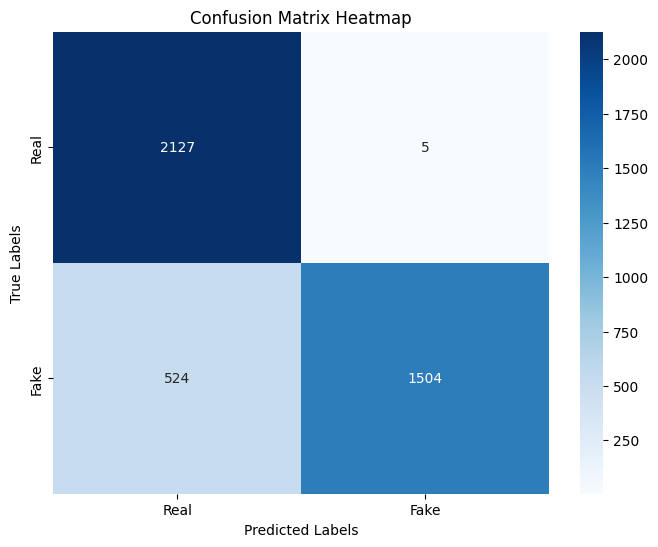

In [29]:
plot_confusion_matrix(y_test, y_pred_NB)

<a name="2.3"></a>
## 2.3 - Logistic Regression

In [30]:
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10],            # Regularization strength
    'penalty': ['l2', 'l1'],                   # Regularization type
    'solver': ['liblinear']            # Solvers
}

grid_search_LR = GridSearchCV(LogisticRegression(), param_grid_LR, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search_LR.fit(X_train_matrix, y_train)

best_lr_model = grid_search_LR.best_estimator_

# Make predictions with the tuned model
y_pred_LR = best_lr_model.predict(X_test_matrix)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [31]:
print("Classification Report:\n", classification_report(y_test, y_pred_LR))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2132
           1       0.98      0.96      0.97      2028

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



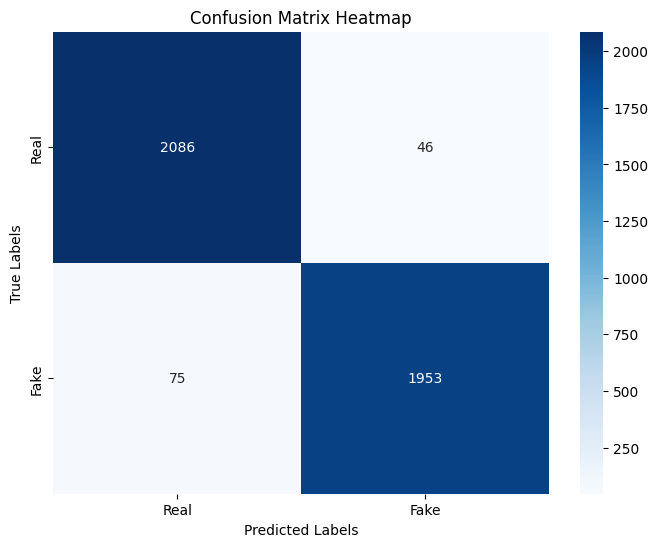

In [32]:
plot_confusion_matrix(y_test, y_pred_LR)

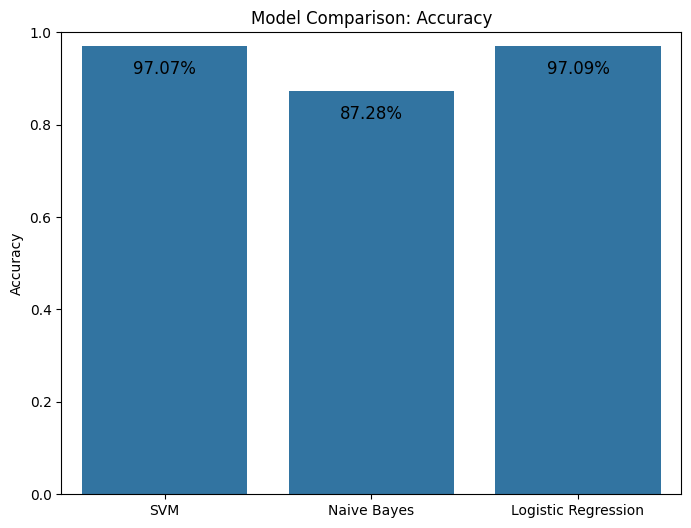

In [53]:
accuracy_values = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_NB), accuracy_score(y_test, y_pred_LR)]

plt.figure(figsize=(8, 6))
sns.barplot(x=["SVM", "Naive Bayes", "Logistic Regression"], y=accuracy_values)

# Add percentage labels on top of bars
for i, accuracy in enumerate(accuracy_values):
    plt.text(i, accuracy-0.05, f'{accuracy * 100:.2f}%', ha='center', va='center', fontsize=12)

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1

# Show the plot
plt.show()

In [55]:
def make_prediction(data, model):
    test_cleaned = [text_prepare(x) for x in data["all_test"]]
    tfidf_data = tfidf.transform(test_cleaned)
    y_pred_LR = model.predict(tfidf_data)
    
    data.index = pd.RangeIndex(start=20800, stop=20800 + len(data), step=1)
    
    pred_data = pd.DataFrame({
    "id": data.index,
    'label': y_pred_LR
    })
    return pred_data

In [56]:
file_to_submit = make_prediction(evaluation_data, best_lr_model)

In [57]:
file_to_submit.to_csv('Predict_LR.csv',index=False)

<div>
<img src="LR_score.webp" width="700"/>
</div>

<a name="3"></a>
## 3 - Neuron Network

In [90]:
def print_history(model, X, y):
    loss, accuracy = model.evaluate(X, y)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    # Plot the training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Make predictions and print classification report
    y_pred = model.predict(X)
    y_pred = (y_pred > 0.5).astype(int)
    print(classification_report(y_test, y_pred))

In [91]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_cleaned)

In [92]:
X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)

In [93]:
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=300)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=300)

<a name="3.1"></a>
## 3.1 - Convolutional NN

In [94]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [95]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=5, batch_size=8, validation_data=(X_test_pad, y_test))

Epoch 1/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8577 - loss: 0.2885 - val_accuracy: 0.9582 - val_loss: 0.1084
Epoch 2/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9861 - loss: 0.0407 - val_accuracy: 0.9635 - val_loss: 0.1080
Epoch 3/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9983 - loss: 0.0065 - val_accuracy: 0.9519 - val_loss: 0.1869
Epoch 4/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9975 - loss: 0.0068 - val_accuracy: 0.9603 - val_loss: 0.1740
Epoch 5/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9627 - val_loss: 0.1886


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9592 - loss: 0.1922
Test Accuracy: 96.27%


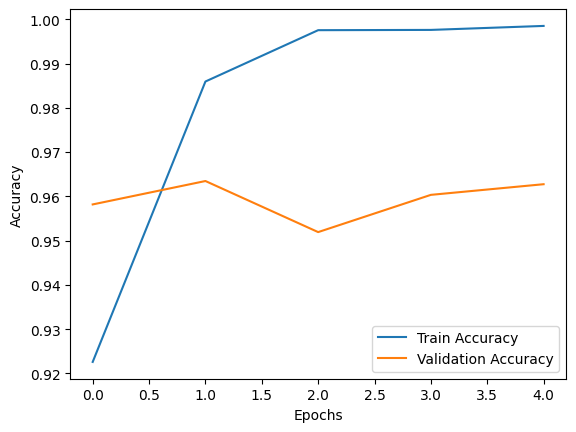

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2132
           1       0.97      0.95      0.96      2028

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



In [96]:
print_history(model, X_test_pad, y_test)

<a name="3.2"></a>
## 3.2 - LSTM

In [97]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=128))
model_lstm.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [98]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
history = model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=8, validation_data=(X_test_pad, y_test))

Epoch 1/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 157s 75ms/step - accuracy: 0.9347 - loss: 0.1739 - val_accuracy: 0.9452 - val_loss: 0.1468
Epoch 2/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 157s 75ms/step - accuracy: 0.9684 - loss: 0.0941 - val_accuracy: 0.9570 - val_loss: 0.1334
Epoch 3/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 157s 75ms/step - accuracy: 0.9848 - loss: 0.0473 - val_accuracy: 0.9531 - val_loss: 0.1590
Epoch 4/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 156s 75ms/step - accuracy: 0.9931 - loss: 0.0230 - val_accuracy: 0.9507 - val_loss: 0.1493
Epoch 5/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 162s 78ms/step - accuracy: 0.9944 - loss: 0.0198 - val_accuracy: 0.9565 - val_loss: 0.1923


130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9503 - loss: 0.2127
Test Accuracy: 95.65%


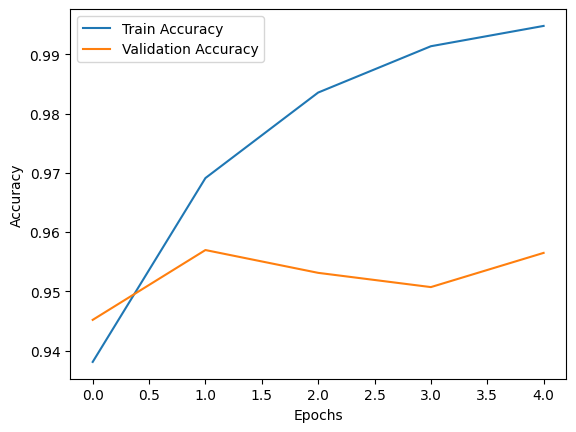

130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2132
           1       0.97      0.94      0.95      2028

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



In [101]:
print_history(model_lstm, X_test_pad, y_test)

<a name="3.3"></a>
## 3.3 - Bidirectional LSTM

In [104]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=5000, output_dim=128))
model_bi_lstm.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model_bi_lstm.add(Dense(1, activation='sigmoid'))
model_bi_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [105]:
model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_bi_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=8, validation_data=(X_test_pad, y_test))

Epoch 1/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 269s 129ms/step - accuracy: 0.8508 - loss: 0.3405 - val_accuracy: 0.9356 - val_loss: 0.1835
Epoch 2/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 265s 127ms/step - accuracy: 0.9582 - loss: 0.1211 - val_accuracy: 0.9365 - val_loss: 0.1874
Epoch 3/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 269s 129ms/step - accuracy: 0.9790 - loss: 0.0651 - val_accuracy: 0.9308 - val_loss: 0.1909
Epoch 4/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 268s 129ms/step - accuracy: 0.9833 - loss: 0.0496 - val_accuracy: 0.9339 - val_loss: 0.2110
Epoch 5/5
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 268s 129ms/step - accuracy: 0.9928 - loss: 0.0240 - val_accuracy: 0.9445 - val_loss: 0.2439


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9413 - loss: 0.2637
Test Accuracy: 94.45%


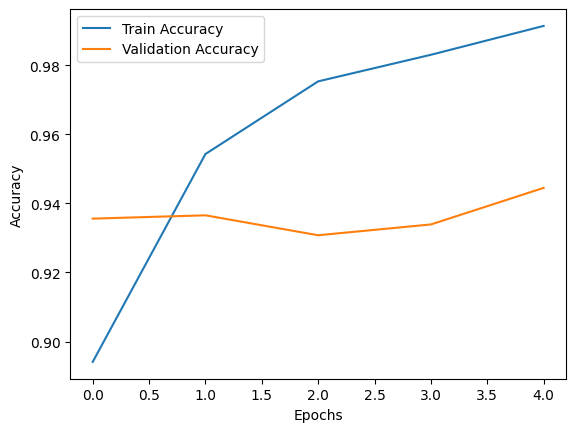

130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2132
           1       0.96      0.92      0.94      2028

    accuracy                           0.94      4160
   macro avg       0.95      0.94      0.94      4160
weighted avg       0.95      0.94      0.94      4160



In [106]:
print_history(model_bi_lstm, X_test_pad, y_test)

<a name="4"></a>
## 4 - Pretrained NN (DistilBert)

In [14]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset

In [15]:
dataset = Dataset.from_pandas(train[["all_test","label"]])
tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def tokenize_function(examples):
    return tokenizer_bert(examples['all_test'], padding='max_length', truncation=True, max_length=256)

In [15]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset, test_dataset = tokenized_datasets.train_test_split(test_size=0.2).values()

Map:   0%|          | 0/20800 [00:00<?, ? examples/s]

In [16]:
training_args = TrainingArguments(
    output_dir='./results',         
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                 
    per_device_train_batch_size=8,       
    per_device_eval_batch_size=8,       
    num_train_epochs=1,                 
    weight_decay=0.01,                 
    logging_dir='./logs',               
    logging_steps=10,
    save_steps=500,                    
    load_best_model_at_end=True,        
)

In [17]:
trainer = Trainer(
    model=model,                         
    args=training_args,                
    train_dataset=train_dataset,        
    eval_dataset=test_dataset,       
    tokenizer=tokenizer_bert
)

/var/folders/tr/8w0nm2r933q2n7ws8zrfc_n40000gn/T/ipykernel_2624/1936906178.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.000400,0.005624


TrainOutput(global_step=2080, training_loss=0.030630782339498043, metrics={'train_runtime': 863.3158, 'train_samples_per_second': 19.275, 'train_steps_per_second': 2.409, 'total_flos': 1102128756817920.0, 'train_loss': 0.030630782339498043, 'epoch': 1.0})

In [19]:
predictions_test = trainer.predict(test_dataset)

In [20]:
predicted_labels = predictions_test.predictions.argmax(axis=-1)
true_labels = test_dataset["label"]

In [21]:
accuracy_score(true_labels,predicted_labels)

0.9987980769230769

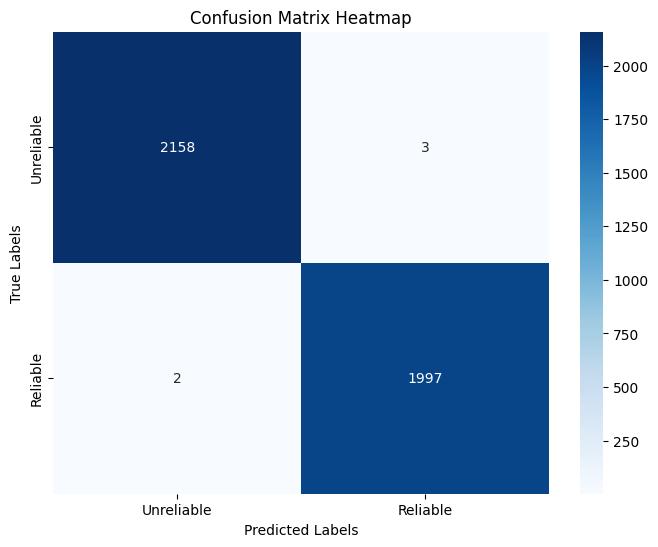

In [26]:
plot_confusion_matrix(true_labels,predicted_labels)

In [ ]:
model.save_pretrained('/Users/sergeiakhmadulin/My Drive/Fake news/distilbert_model')
tokenizer_bert.save_pretrained('/Users/sergeiakhmadulin/My Drive/Fake news/distilbert_model')

In [18]:
model_2 = AutoModelForSequenceClassification.from_pretrained('/Users/sergeiakhmadulin/My Drive/Fake news/distilbert_model')
tokenizer_2 = AutoTokenizer.from_pretrained('/Users/sergeiakhmadulin/My Drive/Fake news/distilbert_model')

In [24]:
def tokenize_function_pred(texts):
    return tokenizer_2(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
def model_eval(inputs, model):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradients to save memory and computations
        outputs = model(**inputs)
        logits = outputs.logits  # Get the raw logits
    predictions = torch.argmax(logits, dim=1).numpy()
    return predictions

def make_prediction(data, model):
    if isinstance(data, object):
        inputs = tokenize_function_pred(evaluation_data["all_test"].tolist())
        predictions = model_eval(inputs, model)
        data.index = pd.RangeIndex(start=20800, stop=20800 + len(data), step=1)
        pred_data = pd.DataFrame({
        "id": data.index,
        'label': predictions
        })
    else:
        inputs = tokenizer_2(data, padding=True, truncation=True, max_length=128, return_tensors="pt")
        pred_data = model_eval(inputs, model)[0] 
    return pred_data

In [25]:
pred_for_submition = make_prediction(evaluation_data, model_2)

In [26]:
pred_for_submition.to_csv('Bert_model_1.csv',index=False)

<div>
<img src="Bert_score.webp" width="700"/>
</div>